# ECI2017 Bayesian Models class Assignment

### Student: Juan Cruz Barsce (jbarsce@gmail.com)


In this assignment, your task will be to implement and analyze Variational Bayesian (VB) inference for Gaussian Mixture Model (GMM) as described in the slides on [Approximate Inference in Bayesian Models](http://www.fit.vutbr.cz/~burget/BayesianModels/4-Approximate%20inference.pdf). The preferred and easiest way of accomplishing this task is to complete this Jupyter Notebook, which already comes with training data definition and a code for Maximum Likelihood (ML) training of a contrastive GMM system. If you do not have any experience with Jupyter Notebook, the easiest way to start is to install Anaconda2, run Jupyter Notebook and open the notebook downloaded from http://www.fit.vutbr.cz/~burget/BayesianModels/ECI2017_BayesianModels_Assignment.ipynb. You can also benefit from reusing pieces of code from the Jupyter Notebooks provided for this class, namely: [bayesian_inference_for_gaussian.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/bayesian_inference_for_gaussian.ipynb) and [gs_gmm_training.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/gs_gmm_training.ipynb).


The following cell contains a code with the definition of training data and the contrastive system training. You should no edit this part! The code does the following:

1. We "handcraft" a GMM (i.e. define GMM parameters) with 4 Gaussian components, which represents the "true distribution" of training data.
2. We have pre-generated training data from this GMM (see definition of variable x), so that everyone works with exactly the same data.
3. GMM with C=6 components is trained on the training data using ML training (the standard EM algorithm). You will use this GMM as a contrastive model. You will compare it to your implementation of VB GMM.
4. The following plots are made:
 * The true training data distribution (in grey).
 * The training observation generated from this true GMM (black + at the x axis).
 * The ML GMM estimate obtained using the EM algorithm (in black)

Time ellapsed for convergence 0.265415898998981


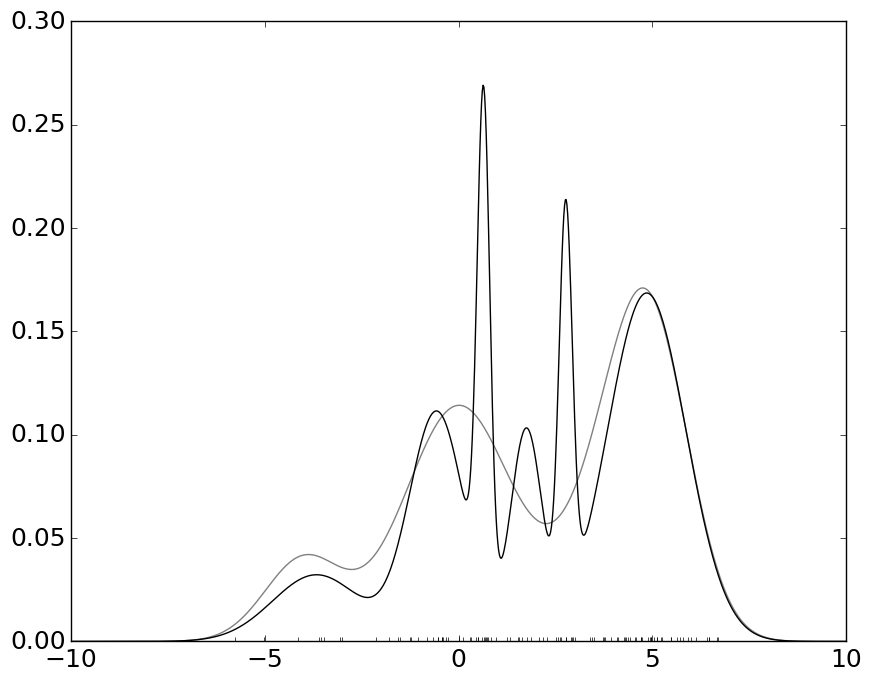

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import timeit
from scipy.misc import logsumexp
from scipy.special import digamma
%matplotlib inline 
#%matplotlib qt5 #get an extra window for the plots
plt.rcParams.update({'figure.figsize': (10.0, 8.0), 'font.size': 18}) #Make the plots bigger


def GMM_pdf(x, mus, vars, pis):
  # Function for evaluating univariate GMM at values given by vector 'x'
  # 'mus', 'vars', 'pis' are vectors of means, variances and weights of individual Gaussian components
  # 'x[:,np.newaxis]' makes 'x' column vector to evaluate every coefficient of 'x' w.r.t. every Gaussian
  # component (row vectors 'mus' and 'vars') at once
  return sps.norm.pdf(x[:,np.newaxis], mus, np.sqrt(vars)).dot(pis) 


#1. Handcraft some GMM parameter 
mus_true = [-4.0, 0.0, 4.0, 5]
vars_true = [1.0, 1.96, 1.44, 1]
pis_true = [0.1, 0.4, 0.2, 0.3]

#2. Pregenerated N datapoints from the GMM distribution above 
x=np.array([ -3.07371088e+00, -4.14348725e+00, -3.01490821e+00, -3.54303388e+00, -3.48708234e+00, -3.59262207e+00,
 -5.76100178e+00, -5.02726789e+00, 8.28817153e-04, 4.99898450e-01, 2.83745605e-01, 6.71947042e-01,
 7.66679495e-01, 6.96995763e-01, 1.33546855e+00, 6.03847649e-01, -1.05992122e+00, 2.91024229e+00,
 -2.12682520e+00, 8.33533885e-01, 1.77147857e+00, 7.37629536e-01, -1.25040836e+00, 1.87318623e+00,
 -4.14582880e-01, 5.05680493e-01, 1.63091140e+00, 6.63219549e-01, -3.30841863e-01, -1.21874646e+00,
 2.64384057e+00, -4.32674840e-01, -1.79034947e+00, 3.13567565e-01, -5.43911715e-01, 2.28572951e+00,
 9.55653291e-01, -5.43582974e-01, -2.73850574e-01, -1.50383720e+00, 1.15925073e-01, 3.92541838e+00,
 -1.57267817e+00, 4.43581114e-01, -8.11856886e-01, 2.62442641e+00, -4.36298436e-01, -6.72286580e-01,
 1.52223784e+00, 1.25033658e+00, 4.88645989e+00, 2.96110183e+00, 4.74249957e+00, 2.17531545e+00,
 3.43072143e+00, 3.49315547e+00, 2.51223591e+00, 2.55369053e+00, 2.93122261e+00, 6.40247818e+00,
 5.12748233e+00, 4.08277439e+00, 4.96716209e+00, 1.56304959e+00, 4.31869585e+00, 2.07957592e+00,
 4.56265393e+00, 3.74342366e+00, 4.36177483e+00, 5.21824922e+00, 4.94100019e+00, 4.70062989e+00,
 6.12111884e+00, 6.69125720e+00, 5.03104495e+00, 5.72199065e+00, 4.29367941e+00, 3.72747772e+00,
 4.41461701e+00, 5.48741263e+00, 4.56782193e+00, 6.45701533e+00, 5.49118936e+00, 4.25947605e+00,
 3.39235348e+00, 4.10586407e+00, 2.76696554e+00, 6.66059909e+00, 6.00107916e+00, 5.92828295e+00,
 4.97460855e+00, 2.77746143e+00, 2.99416076e+00, 5.24459233e+00, 6.44720235e+00, 4.71084807e+00,
 5.62475093e+00, 3.76422931e+00, 5.79482964e+00, 5.11432194e+00])



#3. Choose some initial GMM parameters for EM training
C = 6                             # number of GMM components 
mus_ml = x[:C]                    # We choose few first observations as the initial means
vars_ml = np.repeat(np.var(x), C) # Variances for all components are set to the global variance of the training data
pis_ml = np.ones(C)/C             # All component weights are set to the same value 1/C


start_time = timeit.default_timer()

#EM algorithm for ML GMM training
for _ in range(1000):
  #E-step
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus_ml, np.sqrt(vars_ml)) + np.log(pis_ml)
  log_p_x  = logsumexp(log_p_xz, axis=1, keepdims=True)
  gammas = np.exp(log_p_xz - log_p_x)
    
  #M-step
  Nc = gammas.sum(axis=0)
  mus_ml  =  x.dot(gammas) / Nc
  vars_ml =  (x**2).dot(gammas) / Nc - mus_ml**2
  pis_ml  = Nc / Nc.sum()

elapsed = timeit.default_timer() - start_time
print('Time ellapsed for convergence', elapsed)

#4. Plot the true GMM, ML trained GMM and the observations
t = np.linspace(-10,10,1000)
true_GMM_pdf = GMM_pdf(t, mus_true, vars_true, pis_true)
ml_GMM_pdf  = GMM_pdf(t, mus_ml, vars_ml, pis_ml)
plt.plot(t, true_GMM_pdf, 'gray')
plt.plot(t, ml_GMM_pdf, 'k')
plt.plot(x, np.zeros_like(x), '+k')

## Variational Bayes update formulae

$$
\DeclareMathOperator{\YY}{\boldsymbol{Y}}
\DeclareMathOperator{\ppi}{\boldsymbol{\pi}}
\DeclareMathOperator{\mmu}{\boldsymbol{\mu}}
\DeclareMathOperator{\llambda}{\boldsymbol{\lambda}}
\DeclareMathOperator{\aalpha}{\boldsymbol{\alpha}}
\DeclareMathOperator{\dts}{\mathinner{\ldotp\ldotp}}
$$

Here we summarize the VB update formulas which you need to implement:

* For all $c=1..C$, update parameters of $q(\mu_c, \lambda_c)^*=\mathrm{NormalGamma}\left(\mu_c,\lambda_c \mid m_c^*, \kappa_c^*, a_c^*, b_c^*, \right)$:
$$\begin{align*}
\\
m_c^* & = \frac{\kappa_0 m_0+N_c \bar{x}_c}{\kappa_0+N_c} & &N_c  = \sum_n \gamma_{nc} \\
\kappa_c^* &= \kappa_0+N_c                      & &\bar{x}_c =\frac{\sum_n \gamma_{nc}x_n}{\sum_n \gamma_{nc}}\\
a_c^* &= a_0+\frac{N_c}{2}                      & &s_c =\frac{\sum_n \gamma_{nc}(x_n-\bar{x}_c)^2}{\sum_n \gamma_{nc}}\\
b_c^* &= b_0+\frac{N_c}{2}\left(s_c+\frac{\kappa_0 (\bar{x}_c-m_0)^2}{\kappa_0+N_c}\right)\\
\\
\end{align*}$$
where $\gamma_{nc}$ are the responsibilities defined below in the update of $q(z_n)^*$. For the first VB iteration, use the responsibilities from the last iteration of the EM algorithm above (i.e. use the current setting of the variable 'gammas')

* Update parameters of $q(\boldsymbol{\pi})^*=\mathrm{Dir}(\ppi \mid \aalpha^*)$:
$$\begin{align*}
\\
& \aalpha^*=[\alpha_1^*, \alpha_2^*, \dots, \alpha_C^*] \\
& \alpha_c^*=\alpha_0+N_c\\
\\
\end{align*}$$

* For all $n=1..N$, update distributions $q(z_n)^*$, which are the approximate posterior probabilities for assigning  observations to Gaussian components (i.e. the responsibilities $\gamma_{nc}$):
$$\begin{align*}
\\
& \rho_{nc} = \exp\left(\psi(\alpha_c^*)-\psi\left(\sum_c\alpha_c^*\right)+\frac{\psi(a_c^*)-\ln b_c^*}{2}-\frac{1}{2\kappa_c^*}-\frac{a_c^*}{2b_c^*}(x_n-m_c^*)^2\right)\\
& \gamma_{nc}=\frac{\rho_{nc}}{\sum_c \rho_{nc}}\\
\\
\end{align*}$$
where $\psi(a)$ is digamma function (e.g. scipy.special.digamma)

* Iterate until the convergence (i.e. until there is not significant change when updating the parameters. Alternatively, you can try to derive and implement evaluation of the evidence lower bound function $\mathcal{L}(q(\YY))$ and use it to monitor the convergence).

In the equations abowe, parameters $m_0, \kappa_0, a_0, b_0$ are the parameters of the NormalGamma priors $p(\mu_c, \lambda_c)$. The same prior is used for all Gaussian components $c \in \{1\dts C\}$. Parameter $\alpha_0$ is the parameters of the Dirichlet prior distribution of the component weights $p(\ppi)$. Note that Dirichlet distribution is, in general, parametrized by vector $\aalpha_0$. However, we set all its coefficients to the same value. Therefore only single scalar parameter $\alpha_0$.

For your VB-GMM implementation, use the following setting of the prior parameters!

In [2]:
# Parameters of NormalGamma prior over means (mu) and precision (lambda)
m0, kappa0, a0, b0=[0.0, 0.05, 0.05, 0.05] 

#Parameters of Dirichlet prior weights
alpha0=1.0

Now, code the update formulas for the VB approximation.

* Use the responsibilities (variable 'gammas') obtained from the ML training (EM algorithm implemented above) to initialize the assignments of observations to Gaussian components. This implies that we use the same number of Gaussian components $C=6$ as for the ML training.

* Run iteratively the updates until the algorithm converges.

In [3]:
def NormalGamma_pdf(mu, lmbd, m, kappa, a, b):
    # sps.norm.pdf takes mean and std (not variance), therefore 1.0/
    # sps.gamma.pdf takes shape and scale (not rate), therefore 1.0/b
    return sps.norm.pdf(mu, m, 1.0/np.sqrt(lmbd*kappa))* sps.gamma.pdf(lmbd, a, scale=1.0/b)

def NormalGamma_rvs(m, kappa, a, b, N):
    """NormalGamma """
    # Sample from NormalGamma distribution
    lmbd = sps.gamma.rvs(a, scale=1.0/b, size=N)
    mu = sps.norm.rvs(m, 1.0/np.sqrt(lmbd*kappa), N)
    return mu, lmbd

def NormalGamma_plot(m0, kappa0, a0, b0, limits):
   mu_vals, lmbd_vals = np.meshgrid(np.linspace(limits[0], limits[1], 500), np.linspace(limits[2], limits[3], 500))
   pdf = NormalGamma_pdf(mu_vals, lmbd_vals, m0, kappa0, a0, b0)
   plt.imshow(pdf, origin='lower', cmap='Greys', extent=limits)
   plt.xlabel('$\mu$'); plt.ylabel('$\lambda$')
   plt.show()

In [4]:
# ------------------------------
# Initialization of the variables
# ------------------------------

C = 6
N = np.shape(x)[0]
Nc = np.zeros(C)

mc_star = m0 * np.ones(C)
kappac_star = kappa0 * np.ones(C)
ac_star = a0 * np.ones(C)
bc_star = b0 * np.ones(C)

gammac = np.copy(gammas)  # gammac are the responsabilities

alpha_star = alpha0 * np.ones(C)

ronc = np.reshape(np.zeros(C*N), [N,C])

# Variables below are defined to test if the algorithm converged
mc_star_old = np.copy(mc_star)
kappac_star_old = np.copy(kappac_star)
ac_star_old = np.copy(ac_star)
bc_star_old = np.copy(bc_star)
alpha_star_old = np.copy(alpha_star)
gammac_old = np.copy(gammac)

In [5]:
start_time = timeit.default_timer()

for iteration in range(1000):

    # -------------------------------
    # q(mu, lambda) parameters update
    # -------------------------------

    for i in range(C):

        Nc[i] = np.sum(gammac[:, i])
        xc_bar = np.inner(gammac[:, i], x) / np.sum(gammac[:, i])

        sc = np.inner(gammac[:, i], (x - xc_bar)**2) / np.sum(gammac[:, i])

        mc_star[i] = (kappa0 * m0 + Nc[i] * xc_bar) / (kappa0 + Nc[i])
        kappac_star[i] = kappa0 + Nc[i]
        ac_star[i] = a0 + Nc[i] / 2
        bc_star[i] = b0 + (Nc[i] / 2) * (sc + (kappa0 * (xc_bar - m0)**2) / (kappa0 + Nc[i]))

    # --------------------------------
    # q(pi) parameters update
    # --------------------------------

    for i in range(C):
        alpha_star[i] = alpha0 + Nc[i]

    # --------------------------------
    # Distribution update
    # --------------------------------

    for i in range(N):
        for j in range(C):
            ronc[i, j] = np.exp(digamma(alpha_star[j])
                                - digamma(np.sum(alpha_star[:]))
                                + (digamma(ac_star[j]) - np.log(bc_star[j]))/2
                                - 1/(2*kappac_star[j]) 
                                - (ac_star[j]/(2*bc_star[j])) * (x[i] - mc_star[j])**2)

    for i in range(N):
        for j in range(C):
            gammac[i, j] = ronc[i, j] / np.sum(ronc[i, :])

    # --------------------------------
    # Convergence is checked
    # --------------------------------
    
    error = (np.linalg.norm(mc_star_old - mc_star) 
             + np.linalg.norm(kappac_star_old - kappac_star)
             + np.linalg.norm(ac_star_old - ac_star)
             + np.linalg.norm(bc_star_old - bc_star)
             + np.linalg.norm(alpha_star_old - alpha_star)
             + np.linalg.norm(gammac_old - gammac))

    if (error) < 1e-10:
        print('Convergence reached at iteration ', iteration, 'with error=', error)
        break
    else:
        if iteration == 10000:
            print('Convergence not reached')
        else:    
            mc_star_old = np.copy(mc_star)
            kappac_star_old = np.copy(kappac_star)
            ac_star_old = np.copy(ac_star)
            bc_star_old = np.copy(bc_star)
            alpha_star_old = np.copy(alpha_star)
            gammac_old = np.copy(gammac)

elapsed = timeit.default_timer() - start_time
print('Time ellapsed for convergence', elapsed)

Convergence reached at iteration  490 with error= 9.90006229282e-11
Time ellapsed for convergence 4.71547235899925


Once the VB model is trained:

* Plot the estimated approximate distributions $q(\mu_c,\lambda_c)$ for all the Gaussian components $c \in \{1\dts C\}$. You can reuse the code for plotting NormalGamma distribution from [bayesian_inference_for_gaussian.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/bayesian_inference_for_gaussian.ipynb) notebook.

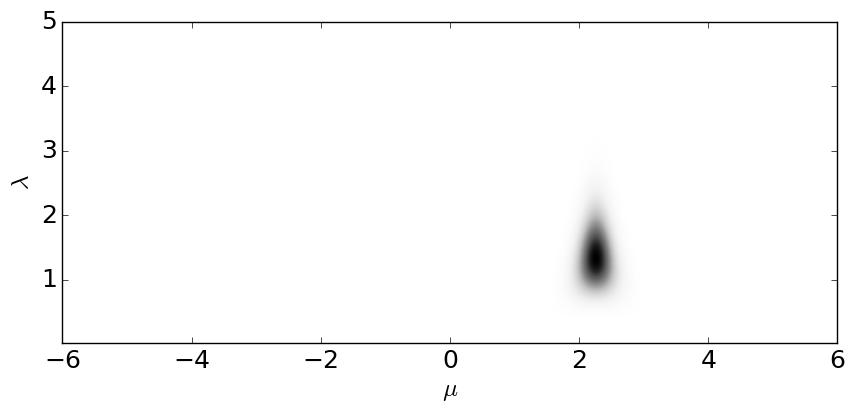

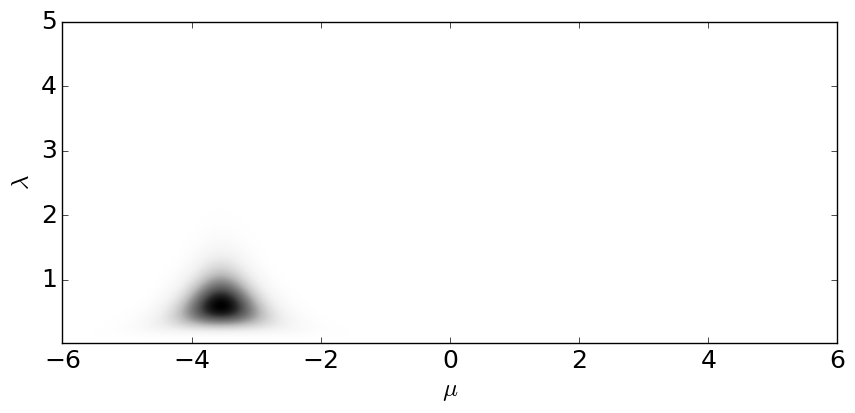

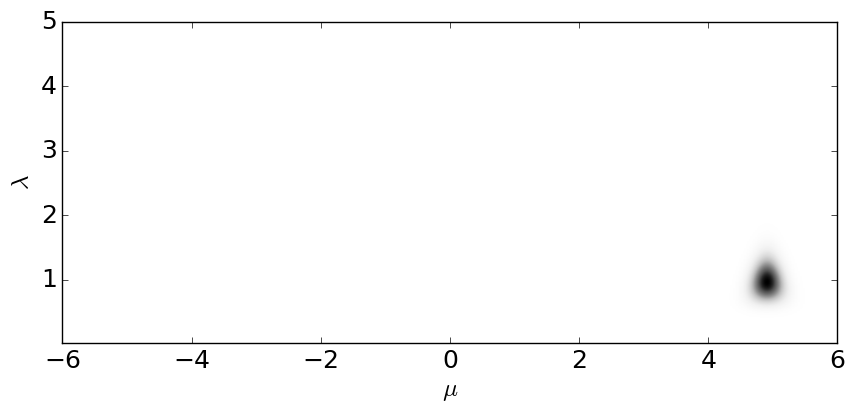

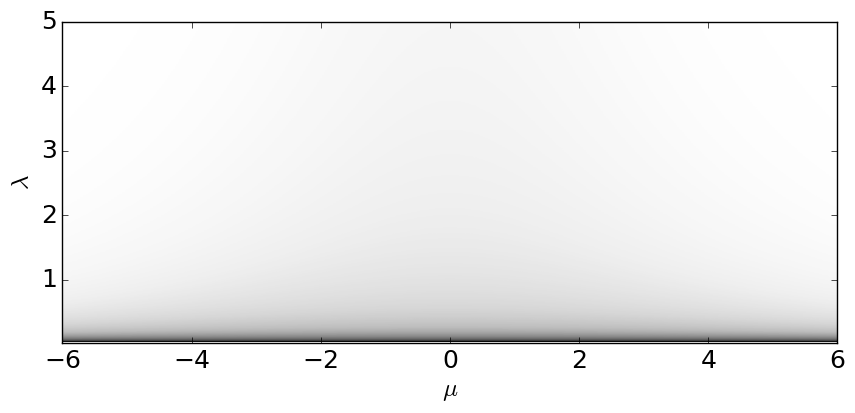

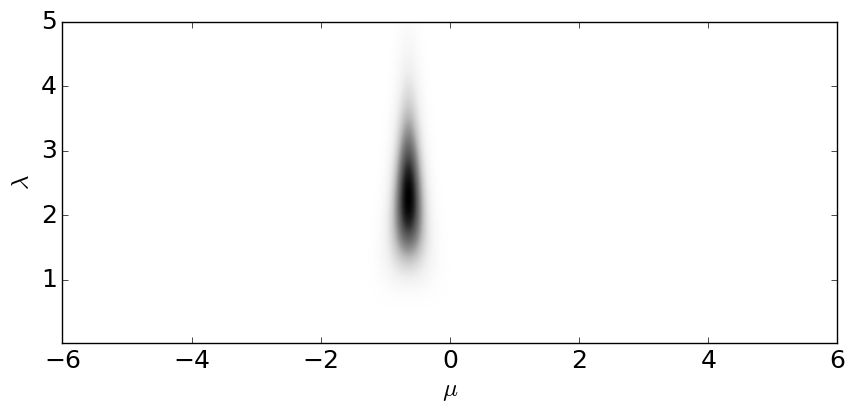

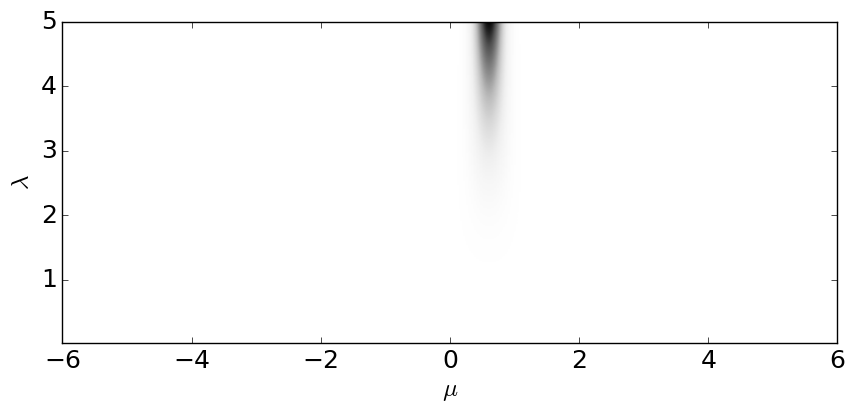

In [6]:
# Estimated distributions are plotted

for i in range(C):
    NormalGamma_plot(m0=mc_star[i], a0=ac_star[i], b0=bc_star[i], kappa0=kappac_star[i], limits=[-6, 6, 0.03, 5])

* Print also the vector of parameters $\aalpha^*$ of the approximate posterior distribution of the weights $q(\ppi)$.

In [7]:
# Alpha vector of approximate posterior distribution q(pi) are shown

print(alpha_star)

[ 22.94897337  10.65232028  41.48595625   1.          18.46250157
  11.45024853]


In [8]:
print(alpha_star / np.sum(alpha_star))

[ 0.21649975  0.10049359  0.39137695  0.00943396  0.17417454  0.10802121]


* Analyze these results. What can you say about the obtained posteriors distributions? What do they represent? How do these posterior distribution compare to the parameter estimates obtained from the EM algorithm?



Answer:

* Looking at the obtained $\boldsymbol{\alpha^\star}$, it can be seen how the third $c$ is by far the most predominant of the six, representing nearly 0.4 of the total weight, followed by the first component, which represents 0.21 of the weight. On the other hand, the 4th component represents nearly 0.01 of the total weight.

* On the other hand, the obtained posterior distributions $q(\mu_c,\lambda_c)$ represents the joint probability distribution between the parameters $\mu_c$ and $\lambda_c$, for each GMM component $c$. It can be appreciated how they are correlated.

* It is notable that the joint distribution plot at the fourth component is missing; this is because their mean and precision are very far off from the limits of the plot.

* Compared with the EM algorithm, it can be seen that the $\mu_c$ are very similar (with the 4th component exception, where in the EM it is well defined) and the $\boldsymbol{\pi}_c$ estimated have a very similar dispersion; on the other hand, the variances obtained in the EM algorithm are higher than those obtained in VB.


* Generate several (say 50) samples from the approximate posterior distribution $q(\ppi,\mmu,\llambda)^* = q(\ppi)^* \prod_{c=1}^C q(\mu_c,\lambda_c)^*$. Each such sample is set of parameters of one GMM. Plot the GMM distributions corresponding to all the samples into a single figure.

In [9]:
# 50 samples of each c are generated

pis = alpha_star / np.sum(alpha_star)
n_samples = 50
mu_samples = np.zeros((50, 6))
lambda_samples = np.zeros((50, 6))
vb_GMM_pdf = []

for i in range(C):
    mu, lambd = NormalGamma_rvs(m=mc_star[i], kappa=kappac_star[i], a=ac_star[i], b=bc_star[i], N=50)
    mu_samples[:, i] = mu
    lambda_samples[:, i] = lambd
    vb_GMM_pdf.append(GMM_pdf(t, mu, lambd**-1, pis[i]))

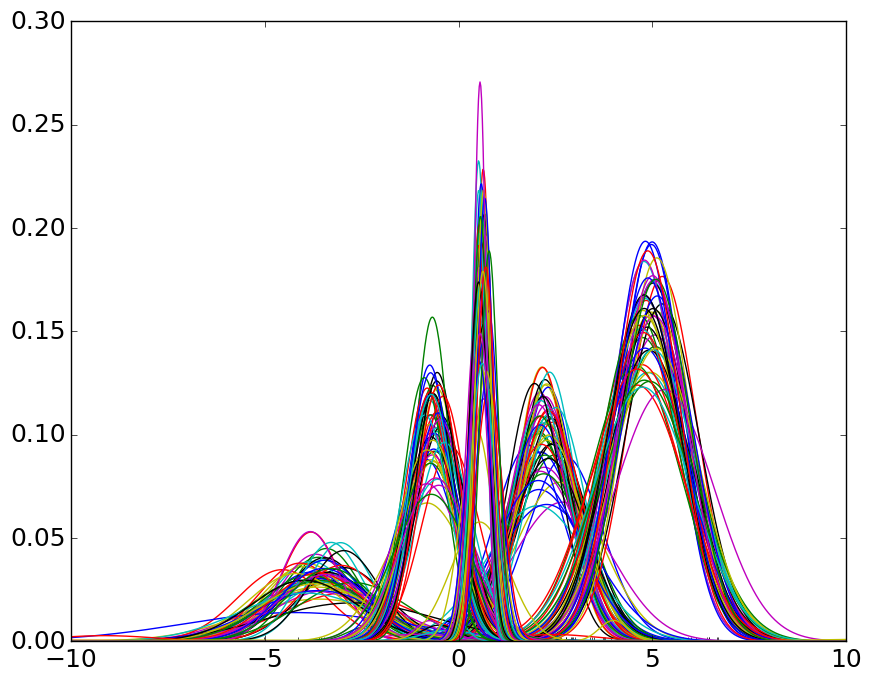

In [10]:
# All the distributions of the samples are plot

plt.plot(x, np.zeros_like(x), '+k')
for i in range(C):
    plt.plot(t, vb_GMM_pdf[i])
plt.show()

Comment on this plot. What do the individual GMM distributions represent?

Answer:

In the plot, several things can be appreciated:

* Each $c$ have all its corresponding sampled distributions clearly separated, with a marked divergence between the different parameters sampled.
* Only five from the six components are seen; the fourth $c$ is not seen because its out of the range of the linespace (its average $\mu$ is -2.13580673455e+15), but displaying it has very little sense because of its extremely low weight.

Each of the individual GMM distributions represent a sample of the GMM for a single parameter estimation of $(\mu_c, \lambda_c)$ for a given component c. $\mu_c$ and $\lambda_c$ are sampled from a $NormalGamma$ distribution with the obtained VB parameters $m^\star_c, a^\star_c, b^\star_c, \kappa^\star_c$, whereas the weights $\boldsymbol{\pi_c}$ are calculated from the obtained $\boldsymbol{\alpha}$ vector from the VB algorithm.


* Now, average all the GMM distributions from the previous step. Attention! Average the GMM distributions, not their parameters as sampled from $q(\ppi,\mmu,\llambda)^*$.

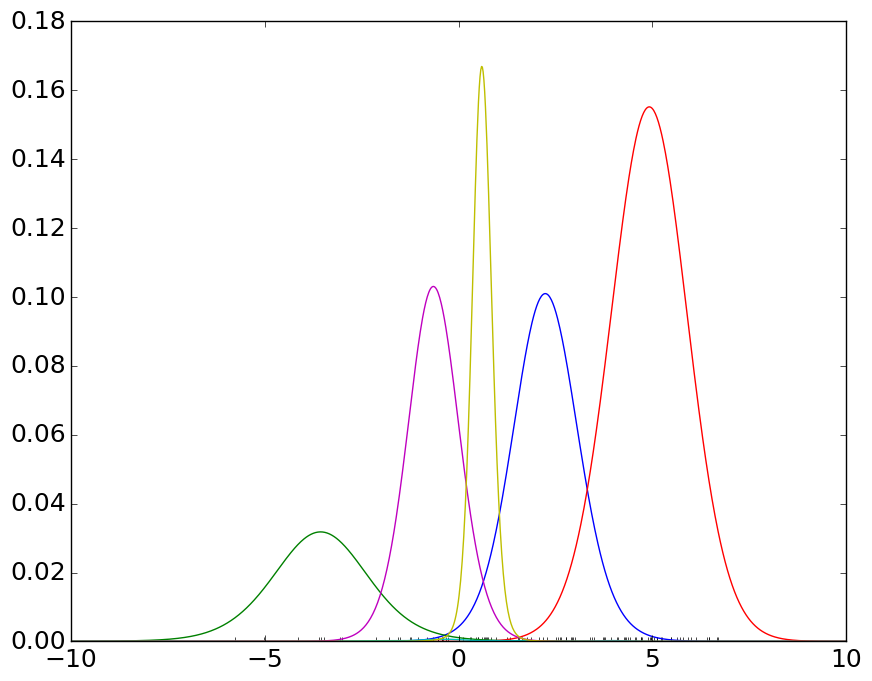

In [11]:
# Code

plt.plot(x, np.zeros_like(x), '+k')
for i in range(C):
    plt.plot(t, np.average(vb_GMM_pdf[i], axis=1))
    
plt.show()

What can you say about the obtained average distribution? What does it represent? Hint: We do similar averaging of GMMs in [gs_gmm_training.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/gs_gmm_training.ipynb).

Answer:

The obtained average distribution represents the mean of every single sample pairs $\mu_{nc}, \lambda_{nc}$, weighted with their correspondent $\pi_c$ for each GMM component. Adding those distributions will give us one averaged prediction for the true GMM distribution.

Now estimate and plot the posterior predictive distribution using the following formula (Note that similar distribution is evaluated in each iteration of Collapsed Gibbs Sampling in [gs_gmm_training.ipynb](http://www.fit.vutbr.cz/~burget/BayesianModels/gs_gmm_training.ipynb)):

$$\begin{align*}
\\
& p(x')=\sum_c St\left(x'\mid m_c^*,2a_c^*,\frac{a_c^* \kappa_c^*}{b_c^*(\kappa_c^*+1)}\right)\frac{\alpha_c^*}{\sum_c \alpha_c^*}\\
\\
\end{align*}$$


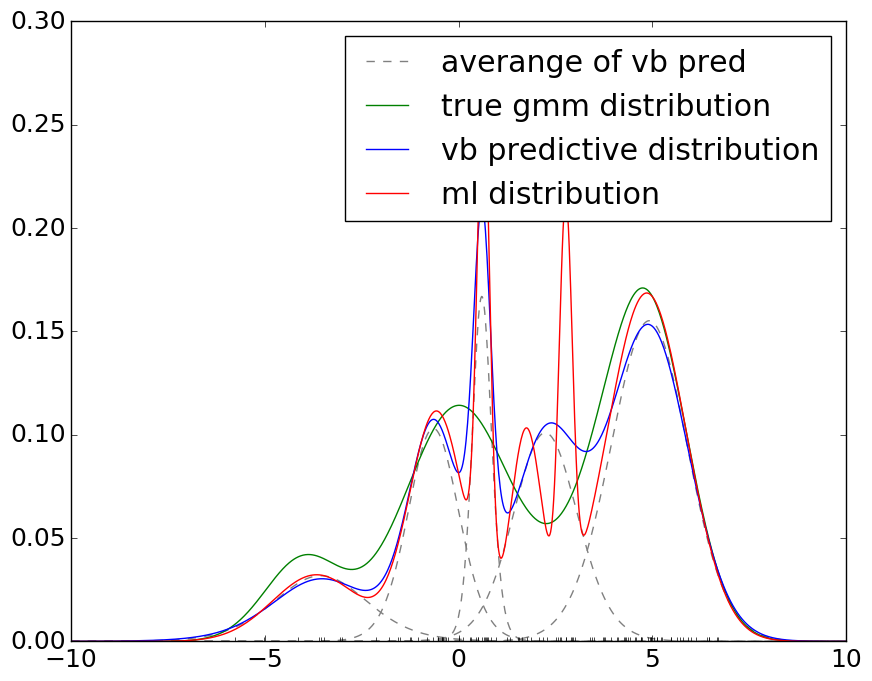

In [12]:
# Your code for posterior predictive distribution

pdf = sps.t.pdf(t[:,np.newaxis], 
                loc=mc_star, 
                df=2*ac_star, 
                scale=np.sqrt(bc_star*(kappac_star+1)/ac_star/kappac_star)).dot(pis)
for i in range(C):
    if i == C-1:
        plt.plot(t, np.average(vb_GMM_pdf[i], axis=1), 'r--', c='grey',  label='averange of vb pred')
    else:
        plt.plot(t, np.average(vb_GMM_pdf[i], axis=1), 'r--', c='grey')
plt.plot(t, true_GMM_pdf, 'green', label='true gmm distribution')
plt.plot(t, pdf, label='vb predictive distribution')
plt.plot(t, ml_GMM_pdf, 'red', label='ml distribution')
plt.plot(x, np.zeros_like(x), '+k')
plt.legend(loc='best')
plt.show()

How does the resulting posterior predictive distribution compare to:
- the true training data distribution
- the GMM obtained using ML training (i.e. using EM algorithm)
- the average of GMM distributions obtained in the previous step by sampling from $q(\ppi,\mmu,\llambda)^*$

Answer:

* The resulting posterior distribution gets some of the shape of the true distribution, especially at the beginning and (mostly) at the end, but it overfits a lot in between the second peak and up to t=4.

* Compared with the EM posterior, the resulting posterior is more smooth and has less overfit than the posterior generated with EM. There are more peaks in the EM distribution, and those reach higher than the peaks generated with VB.

* Considering the GMM distributions obtained in the previous step, it can be seen how they adds up, and how the 3rd and 4th Gaussians are those that makes the posterior distribution to be far from the true at those points. It can also be seen that the 1st and the 5th Gaussians at the plot are close to the true distribution.

Generate larger number of training observations (e.g. 1000 samples) from the true distribution (mus_true, vars_true, pis_true) and repeat the whole experiment once more with the larger amount of training data. Regenerate all the plots and comment on how they change from the previous experiments with smaller training data set.

-------------------------------------------

## ** Whole experiment repeated starts here **

-------------------------------------------

In [13]:
# x vector is regenerated with more samples

N = 5000
t = np.linspace(-10,10,N)
true_GMM_pdf = GMM_pdf(t, mus_true, vars_true, pis_true)

Nc = sps.multinomial.rvs(N, pis_true)
x = sps.norm.rvs(np.repeat(mus_true, Nc), np.repeat(np.sqrt(vars_true), Nc))
np.random.shuffle(x)

In [14]:
# -------------
# EM experiment
# -------------

#3. Choose some initial GMM parameters for EM training
C = 6                             # number of GMM components 
mus_ml = x[:C]                    # We choose few first observations as the initial means
vars_ml = np.repeat(np.var(x), C) # Variances for all components are set to the global variance of the training data
pis_ml = np.ones(C)/C             # All component weights are set to the same value 1/C

start_time = timeit.default_timer()

#EM algorithm for ML GMM training
for _ in range(1000):
  #E-step
  log_p_xz = sps.norm.logpdf(x[:,np.newaxis], mus_ml, np.sqrt(vars_ml)) + np.log(pis_ml)
  log_p_x  = logsumexp(log_p_xz, axis=1, keepdims=True)
  gammas = np.exp(log_p_xz - log_p_x)
    
  #M-step
  Nc = gammas.sum(axis=0)
  mus_ml  =  x.dot(gammas) / Nc
  vars_ml =  (x**2).dot(gammas) / Nc - mus_ml**2
  pis_ml  = Nc / Nc.sum()

elapsed = timeit.default_timer() - start_time
print('Time ellapsed for convergence', elapsed)

#4. Plot the true GMM, ML trained GMM and the observations
t = np.linspace(-10,10,1000)
true_GMM_pdf = GMM_pdf(t, mus_true, vars_true, pis_true)
ml_GMM_pdf  = GMM_pdf(t, mus_ml, vars_ml, pis_ml)

Time ellapsed for convergence 4.386374444999092


In [15]:
# --------------------
# Variational Bayes Experiment
# --------------------

# ------------------------------
# Initialization of the variables
# ------------------------------

C = 6
N = np.shape(x)[0]
Nc = np.zeros(C)

mc_star = m0 * np.ones(C)
kappac_star = kappa0 * np.ones(C)
ac_star = a0 * np.ones(C)
bc_star = b0 * np.ones(C)

gammac = np.copy(gammas)  # gammac are the responsabilities

alpha_star = alpha0 * np.ones(C)

ronc = np.reshape(np.zeros(C*N), [N,C])

# Variables below are defined to test if the algorithm converged
mc_star_old = np.copy(mc_star)
kappac_star_old = np.copy(kappac_star)
ac_star_old = np.copy(ac_star)
bc_star_old = np.copy(bc_star)
alpha_star_old = np.copy(alpha_star)
gammac_old = np.copy(gammac)

In [16]:
start_time = timeit.default_timer()

for iteration in range(1000):

    # -------------------------------
    # q(mu, lambda) parameters update
    # -------------------------------

    for i in range(C):

        Nc[i] = np.sum(gammac[:, i])
        xc_bar = np.inner(gammac[:, i], x) / np.sum(gammac[:, i])

        sc = np.inner(gammac[:, i], (x - xc_bar)**2) / np.sum(gammac[:, i])

        mc_star[i] = (kappa0 * m0 + Nc[i] * xc_bar) / (kappa0 + Nc[i])
        kappac_star[i] = kappa0 + Nc[i]
        ac_star[i] = a0 + Nc[i] / 2
        bc_star[i] = b0 + (Nc[i] / 2) * (sc + (kappa0 * (xc_bar - m0)**2) / (kappa0 + Nc[i]))

    # --------------------------------
    # q(pi) parameters update
    # --------------------------------

    for i in range(C):
        alpha_star[i] = alpha0 + Nc[i]

    # --------------------------------
    # Distribution update
    # --------------------------------

    for i in range(N):
        for j in range(C):
            ronc[i, j] = np.exp(digamma(alpha_star[j])
                                - digamma(np.sum(alpha_star[:]))
                                + (digamma(ac_star[j]) - np.log(bc_star[j]))/2
                                - 1/(2*kappac_star[j]) 
                                - (ac_star[j]/(2*bc_star[j])) * (x[i] - mc_star[j])**2)

    for i in range(N):
        for j in range(C):
            gammac[i, j] = ronc[i, j] / np.sum(ronc[i, :])

    # --------------------------------
    # Convergence is checked
    # --------------------------------
    
    error = (np.linalg.norm(mc_star_old - mc_star) 
             + np.linalg.norm(kappac_star_old - kappac_star)
             + np.linalg.norm(ac_star_old - ac_star)
             + np.linalg.norm(bc_star_old - bc_star)
             + np.linalg.norm(alpha_star_old - alpha_star)
             + np.linalg.norm(gammac_old - gammac))

    if (error) < 1e-10:
        print('Convergence reached at iteration ', iteration, 'with error=', error)
        break
    else:
        if iteration == 10000:
            print('Convergence not reached')
        else:    
            mc_star_old = np.copy(mc_star)
            kappac_star_old = np.copy(kappac_star)
            ac_star_old = np.copy(ac_star)
            bc_star_old = np.copy(bc_star)
            alpha_star_old = np.copy(alpha_star)
            gammac_old = np.copy(gammac)
            
elapsed = timeit.default_timer() - start_time            
print('Time ellapsed for convergence', elapsed)

Time ellapsed for convergence 393.5470058330011


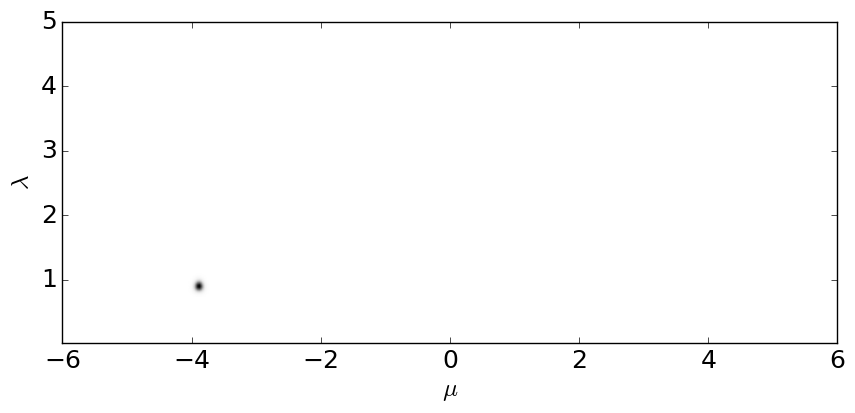

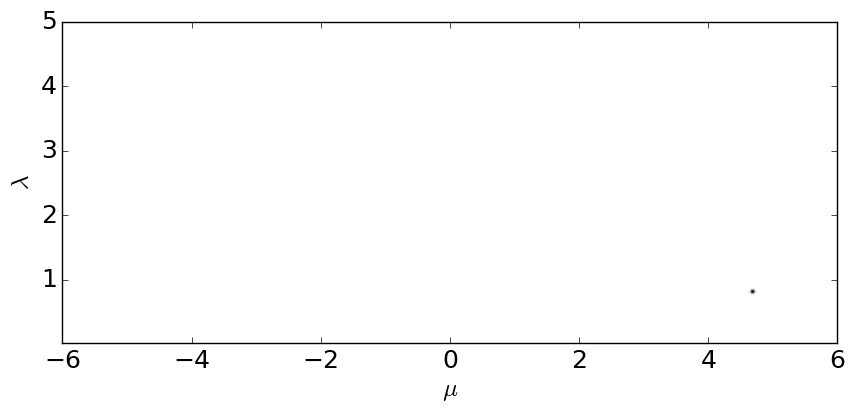

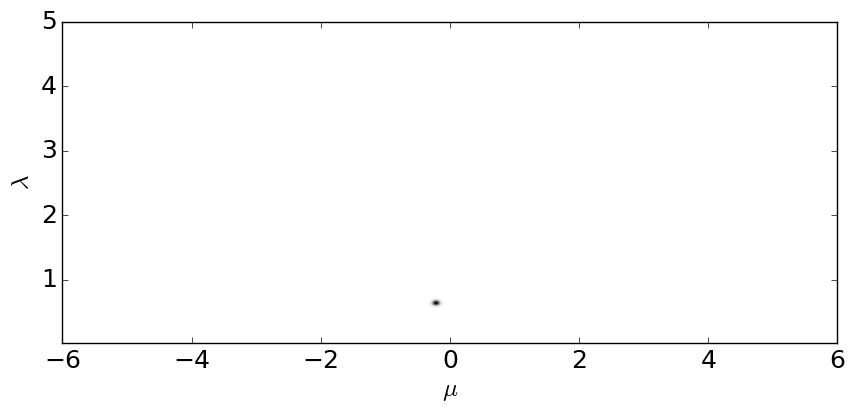

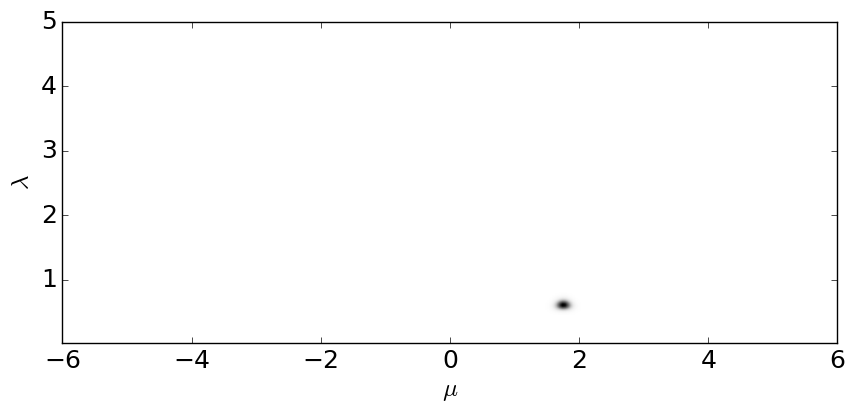

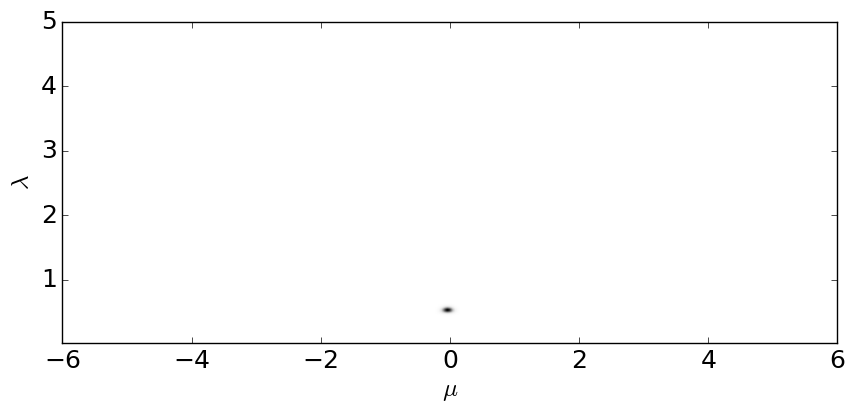

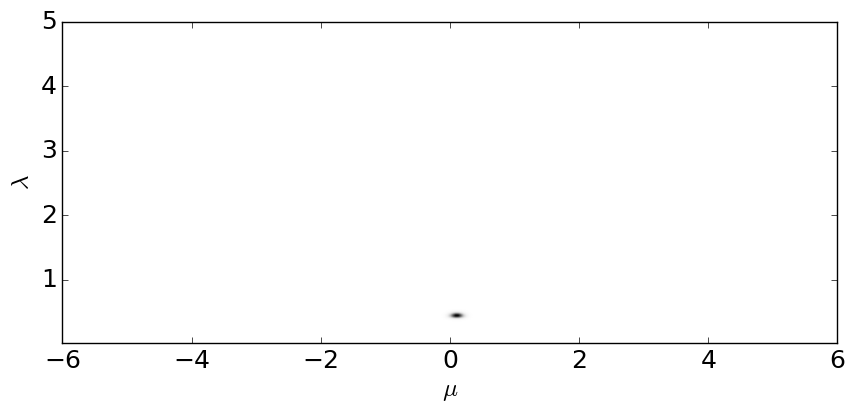

In [17]:
# Estimated distributions are plotted

for i in range(C):
    NormalGamma_plot(m0=mc_star[i], a0=ac_star[i], b0=bc_star[i], kappa0=kappac_star[i], limits=[-6, 6, 0.03, 5])

In [18]:
# Alpha vector of approximate posterior distribution q(pi) are shown

print(alpha_star)
print(alpha_star/np.sum(alpha_star))

[  523.54784553  2315.54153897   851.57690141   258.4452718    591.5727994
   465.31564289]
[ 0.10458407  0.46255324  0.17011125  0.0516271   0.11817275  0.09295159]


In [19]:
# 50 samples of each c are generated

pis = alpha_star / np.sum(alpha_star)
n_samples = 50
mu_samples = np.zeros((50, 6))
lambda_samples = np.zeros((50, 6))
vb_GMM_pdf = []

for i in range(C):
    mu, lambd = NormalGamma_rvs(m=mc_star[i], kappa=kappac_star[i], a=ac_star[i], b=bc_star[i], N=50)
    mu_samples[:, i] = mu
    lambda_samples[:, i] = lambd
    vb_GMM_pdf.append(GMM_pdf(t, mu, lambd**-1, pis[i]))

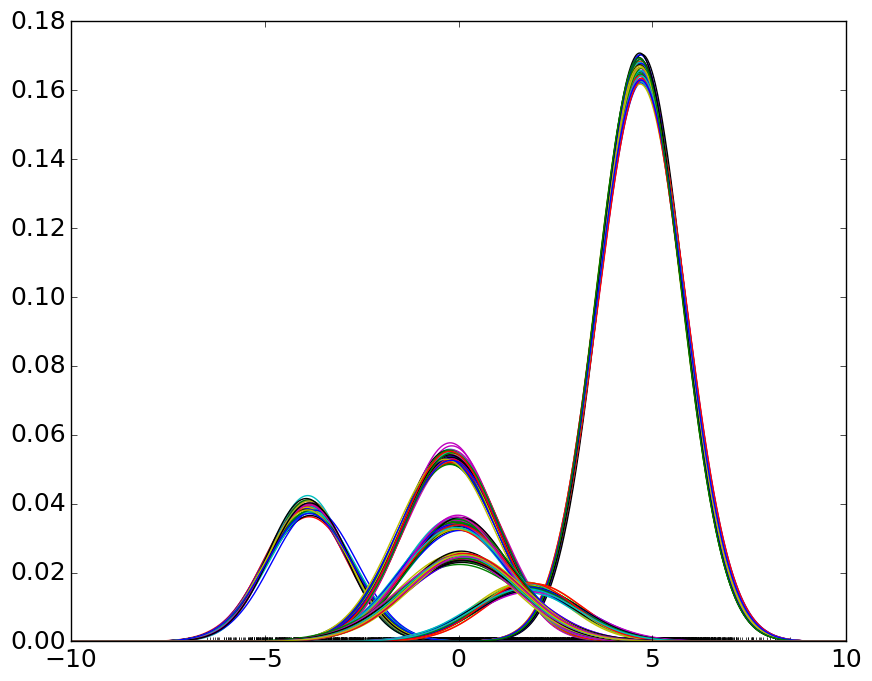

In [20]:
# All the distributions of the samples are plot

plt.plot(x, np.zeros_like(x), '+k')
for i in range(C):
    plt.plot(t, vb_GMM_pdf[i])
plt.show()

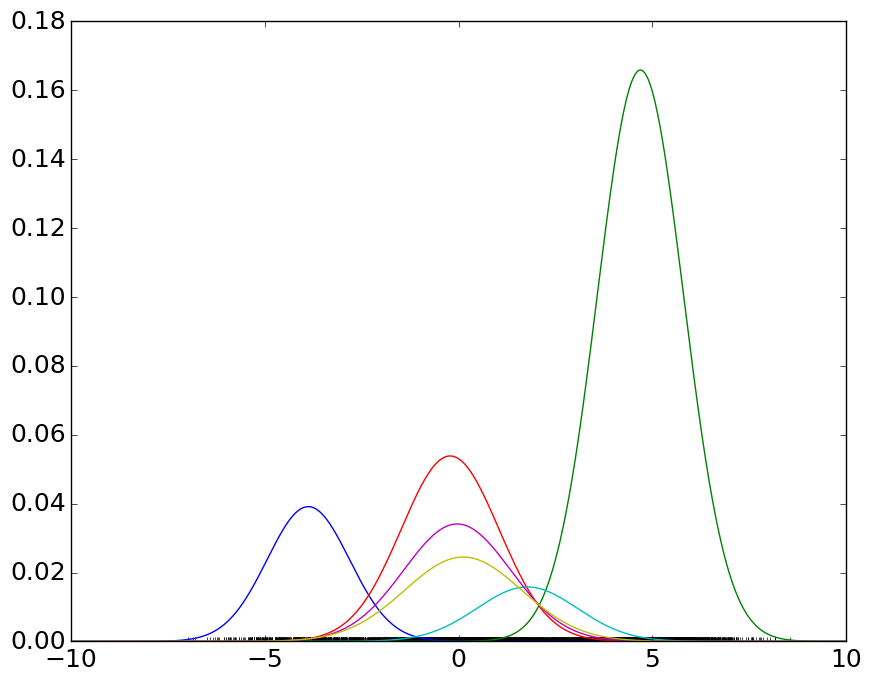

In [21]:
# Code

plt.plot(x, np.zeros_like(x), '+k')
for i in range(C):
    plt.plot(t, np.average(vb_GMM_pdf[i], axis=1))
    
plt.show()

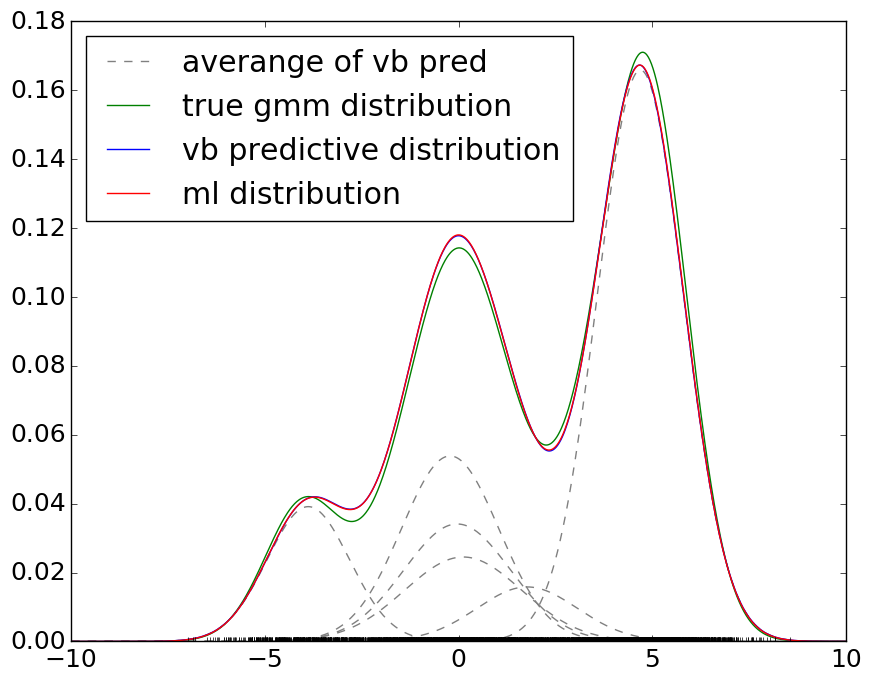

In [23]:
# Your code for posterior predictive distribution

pdf = sps.t.pdf(t[:,np.newaxis], 
                loc=mc_star, 
                df=2*ac_star, 
                scale=np.sqrt(bc_star*(kappac_star+1)/ac_star/kappac_star)).dot(pis)

for i in range(C):
    if i == C-1:
        plt.plot(t, np.average(vb_GMM_pdf[i], axis=1), 'r--', c='grey',  label='averange of vb pred')
    else:
        plt.plot(t, np.average(vb_GMM_pdf[i], axis=1), 'r--', c='grey')
plt.plot(t, true_GMM_pdf, 'green', label='true gmm distribution')
plt.plot(t, pdf, label='vb predictive distribution')
plt.plot(t, ml_GMM_pdf, 'red', label='ml distribution')
plt.plot(x, np.zeros_like(x), '+k')
plt.legend(loc='best')
plt.show()

Comment on how the new plots change from the previous experiments with smaller training data set.

Answer:

Now, with all the experiments repeated with more samples, several things can be commented.

* The $\boldsymbol{\alpha}^\star$ vector is now balanced. Still dominated by a component with 0.46 of the weight (as it is clearly seen in the averaged posteriors), but now all the 6 components contributes to some extent (e.g. the component that less contribute now has a reasonable mean and precision). Respect with the joint distribution of the mean and precision of each component, it is also noticeable that they are now more focused, diverging way less than those of the previous experiment.

* Regarding the distributions sampled from $q(\ppi,\mmu,\llambda)^*$, the most noticeable thing is how little they diverge compared to the same plot in the former experiment. Their average is very easy to see beforehands, as it is confirmed by looking the average samples plot.

* With respect to the posterior predictive distribution, both VB and EM have almost equal distributions, where both are now very close to the true GMM distribution. They have some divergences, but I assume they might be because of the stochastic factor when the new vector of $\boldsymbol{x}$ was sampled.

* As a side note, something that surprised me is how VB takes a lot more time converging with $N \geq 1000$ (06:30 against 00:05 on the former experiment). Based on that, I can imagine why it explodes in high dimensions. On the other hand, EM doesn't take that much and generated similar results (but I imagine that this might be because the true distribution is one-dimensional and simple).

Try to implement as much as you can and answer ans many questions as you can. It is fine if you do not understand some questions or if you do not know some of the answers.